[jieba分词](https://github.com/fxsjy/jieba)

In [1]:
import pandas as pd 
import jieba
import jieba.analyse
import numpy as np
import random 
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from scipy.misc import imread
import warnings 
from sklearn.model_selection import train_test_split
from keras import  Sequential
from keras.layers import Dense,Dropout
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from keras.backend import one_hot
from keras.preprocessing.text import Tokenizer
from keras import  Sequential
from keras.layers import Dense,Dropout
from keras.callbacks import EarlyStopping
from keras.layers import Embedding,BatchNormalization
from keras.layers import Convolution1D, Flatten, Dropout, MaxPool1D, GlobalAveragePooling1D

warnings.filterwarnings('ignore')

D:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df = pd.read_csv('./data/2019S1customer_feedback.csv',encoding='gbk')
df = df.dropna(how = 'any')
df.tail()

,航班号,航班日期,出发地编码,目的地编码,均分,评论
2917,ZH9992,2019/1/8,KHN,CAN,5.00,都不错
2918,ZH9992,2019/1/14,TAO,KHN,2.50,餐食难吃，比路边摊还难吃。客舱拥挤这个已经习惯了，但是呆里面看快两个小时起飞。连饮料都没有。...
2919,ZH9993,2019/1/16,CAN,TAO,4.67,空乘服务好，准时抵达，
2920,ZH9995,2019/1/5,CAN,JJN,5.00,餐食好吃，准时抵达.
2922,ZH9996,2019/1/9,JJN,CAN,4.92,安检很快，机场商品多，餐食好吃，值机快捷，准时抵达，座椅舒适，空乘服务好，/商务舱依旧柜台值...


In [3]:
def emotion(x):
    emo = None
    if x <= 4.5 :
        emo = 'Negative'
    else:
        emo = 'Positive'
    return emo

df['情感'] = df['均分'].apply(lambda x:emotion(x))
df.tail()

,航班号,航班日期,出发地编码,目的地编码,均分,评论,情感
2917,ZH9992,2019/1/8,KHN,CAN,5.00,都不错,Positive
2918,ZH9992,2019/1/14,TAO,KHN,2.50,餐食难吃，比路边摊还难吃。客舱拥挤这个已经习惯了，但是呆里面看快两个小时起飞。连饮料都没有。...,Negative
2919,ZH9993,2019/1/16,CAN,TAO,4.67,空乘服务好，准时抵达，,Positive
2920,ZH9995,2019/1/5,CAN,JJN,5.00,餐食好吃，准时抵达.,Positive
2922,ZH9996,2019/1/9,JJN,CAN,4.92,安检很快，机场商品多，餐食好吃，值机快捷，准时抵达，座椅舒适，空乘服务好，/商务舱依旧柜台值...,Positive


In [4]:
df_groupby_emo = df.groupby(by = '情感')
print('Positive record : %d' %df_groupby_emo.get_group('Positive').shape[0])
print('Negative record : %d' %df_groupby_emo.get_group('Negative').shape[0])

Positive record : 1620
Negative record : 1071


In [5]:
long_sentences = ''.join(df['评论'].values)
#TF-IDF
tf_top10 = jieba.analyse.extract_tags(long_sentences, topK=10, withWeight=False, allowPOS=())
print(tf_top10 )
#TextRank
tr_topK = jieba.analyse.textrank(long_sentences, topK=10, withWeight=False, allowPOS=('ns', 'n', 'vn'))
print(tr_topK)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\aljgq\AppData\Local\Temp\jieba.cache
Loading model cost 0.736 seconds.
Prefix dict has been built succesfully.


['空乘', '值机', '安检', '准时', '餐食', '快捷', '抵达', '服务', '座椅', '很快']
['服务', '机场', '值机', '餐食', '商品', '座椅', '飞机', '小时', '航班', '晚点']


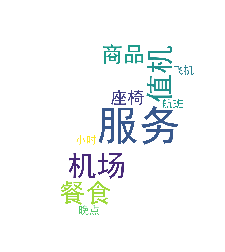

In [6]:
#背景图
bg_pic = imread('mask.jpg')
#生成词云
wordcloud = WordCloud(background_color="white",width=10, scale=6,
                      font_path="C://Windows//Fonts/simhei.ttf",height=8, max_words=30,max_font_size=60,
                    mask = bg_pic).generate(' '.join(tr_topK))

plt.figure(figsize=(6,4))
plt.imshow(wordcloud)
plt.axis("off")
#plt.savefig('logo.png')
wordcloud.to_file('text.png')
plt.show()

In [7]:
stopwords=pd.read_csv("./data/stopwords.txt",index_col=False,quoting=3,sep="\t",names=['stopword'], encoding='utf-8')
stopwords=stopwords['stopword'].values

In [8]:
def preprocess_text(content_lines, sentences):
    for line in content_lines:
        try:
            segs=jieba.lcut(line)
            segs = filter(lambda x:len(x)>1, segs)
            segs = filter(lambda x:x not in stopwords, segs)
            segs = list(segs)
            sentences.append(" ".join(segs))
        except Exception:
            print(line)
            continue 
            
content = df['评论'].values
#生成训练数据
sentences = []
preprocess_text(content, sentences)

In [9]:
sentences[:10]

['机场 晚点 晚点 中国 飞机 正点 起飞',
 '空乘 服务 准时 抵达 安检 很快 很快',
 '安检 很快 机场 商品 餐食 好吃 准时 抵达',
 '餐食 好吃 准时 抵达 值机 快捷',
 '餐食 好吃 安检 很快 值机 快捷 机场 商品',
 '安检 很快 值机 快捷 座椅 舒适 空乘 服务',
 '准时 抵达 空乘 服务 座椅 舒适 安检 很快 餐食 好吃 值机 快捷 机场 商品',
 '准时 抵达 值机 快捷 空乘 服务 一路 平稳 到达',
 '准时 抵达 座椅 舒适 值机 快捷 真心 不错',
 '空乘 服务 座椅 舒适 安检 很快']

In [10]:
sample_amount_n = 1000
sample_amount_p = 1000
pos_content = list(df['评论'][df['情感'] == 'Positive'].values)
neg_content = list(df['评论'][df['情感'] == 'Negative'].values)
random.shuffle(pos_content)
random.shuffle(neg_content)
df_sample_p,df_sample_n = pd.DataFrame(),pd.DataFrame()
df_sample_p['content'] = pos_content[:sample_amount_p]
df_sample_p['emotion'] = 'positive'
df_sample_n['content'] = neg_content[:sample_amount_n]
df_sample_n['emotion'] = 'negative'
df_sample = pd.concat([df_sample_n,df_sample_p],ignore_index=True)

In [11]:
df_sample['emotion'].unique()

array(['negative', 'positive'], dtype=object)

In [12]:
text_content = df_sample['content'].values
text_feature = df_sample['emotion'].values
df_f = pd.DataFrame()
df_f['feature'] = text_feature
text_feature = pd.get_dummies(df_f)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(text_content,text_feature, random_state = 95361,test_size = 0.5)

In [14]:
tokenizer = Tokenizer(num_words = 800,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=False,split=" ")

tokenizer.fit_on_texts(text_content)
vocab = tokenizer.word_index
#vocabulary
X_train_word_ids = tokenizer.texts_to_sequences(x_train)
X_test_word_ids = tokenizer.texts_to_sequences(x_test)

In [15]:
np.save('./saved_model/vocab_dict.npy', vocab) 
print('vocab have been saved!')

vocab have been saved!


In [16]:
# One-hot
X_train_fit = tokenizer.sequences_to_matrix(X_train_word_ids, mode='binary')
X_test_fit = tokenizer.sequences_to_matrix(X_test_word_ids, mode='binary')

In [17]:
model = Sequential()
# 全连接层
model.add(Dense(128, input_shape=(800,), activation='relu'))
# DropOut层
model.add(Dropout(0.5))
# 全连接层
model.add(Dense(64,activation = 'relu'))
# 全连接层+分类器
model.add(Dropout(0.5))

model.add(Dense(2,activation='softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['binary_accuracy'])
# early_stopping
early_stopping = EarlyStopping(monitor='val_binary_accuracy', patience = 3, verbose=2)

model.fit(X_train_fit, y_train,
          batch_size = 16,
          epochs = 20,callbacks=[early_stopping],
          validation_data=(X_test_fit, y_test))
model.evaluate(X_test_fit,y_test,batch_size = 16)[1]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 1000 samples, validate on 1000 samples
Epoch 1/20
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6835 - binary_accuracy: 0.6130 - val_loss: 0.6623 - val_binary_accuracy: 0.7460
Epoch 2/20
1000/1000 [==============================] - 0s 417us/step - loss: 0.6468 - binary_accuracy: 0.7240 - val_loss: 0.6262 - val_binary_accuracy: 0.7460
Epoch 3/20
1000/1000 [==============================] - 0s 327us/step - loss: 0.6000 - binary_accuracy: 0.7280 - val_loss: 0.5862 - val_binary_accuracy: 0.7450
Epoch 4/20
1000/1000 [==============================] - 0s 309us/step - loss: 0.5428 - binary_accuracy: 0.7640 - val_loss: 0.5604 - val_binary_accuracy: 0.7430
Epoch 00004: early stopping
1000/1000 [==============================] - 0s 77u

0.743

In [24]:
cnn_1 = Sequential()
cnn_1.add(Embedding(input_length = 800,input_dim = len(vocab)+1, output_dim = 50))
cnn_1.add(Convolution1D(64, 3, padding='same'))
cnn_1.add(MaxPool1D(3,3,padding='same'))
cnn_1.add(Convolution1D(64, 3, padding='same'))
cnn_1.add(MaxPool1D(3,3,padding='same'))
cnn_1.add(Convolution1D(64, 3, padding='same'))
cnn_1.add(Flatten())
cnn_1.add(Dropout(0.5))
cnn_1.add(BatchNormalization()) # (批)规范化层
cnn_1.add(Dense(32,activation='relu'))
cnn_1.add(Dropout(0.5))
cnn_1.add(Dense(2,activation='softmax'))

cnn_1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['binary_accuracy'])

early_stopping = EarlyStopping(monitor='val_binary_accuracy', patience=5, verbose=2)

cnn_1.fit(X_train_fit, y_train,
          batch_size = 16,
          epochs = 20,callbacks=[early_stopping],
          validation_data=(X_test_fit, y_test))
cnn_1.evaluate(X_test_fit,y_test,batch_size=16)[1]

Train on 1000 samples, validate on 1000 samples
Epoch 1/20
1000/1000 [==============================] - 2s 2ms/step - loss: 0.8996 - binary_accuracy: 0.5100 - val_loss: 0.7186 - val_binary_accuracy: 0.5010
Epoch 2/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.7584 - binary_accuracy: 0.5390 - val_loss: 0.6901 - val_binary_accuracy: 0.5020
Epoch 3/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.7026 - binary_accuracy: 0.5260 - val_loss: 0.7297 - val_binary_accuracy: 0.5010
Epoch 4/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.6959 - binary_accuracy: 0.5230 - val_loss: 0.7117 - val_binary_accuracy: 0.4990
Epoch 5/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.6854 - binary_accuracy: 0.5500 - val_loss: 0.9454 - val_binary_accuracy: 0.5010
Epoch 6/20
1000/1000 [==============================] - 1s 777us/step - loss: 0.6420 - binary_accuracy: 0.6360 - val_loss: 1.0959 - val_binary_accuracy: 0.5180
Ep

0.764

In [19]:
cnn_1.save('./saved_model/cnn_model.h5')
print('model saved!')

model saved!


In [20]:
def get_predict_result(something):
    sentences_ = []
    segs_ = jieba.lcut(something)
    sentences_.append(" ".join(segs_))
    transform_sentence = tokenizer.texts_to_sequences(sentences_)
    one_hot_return = tokenizer.sequences_to_matrix(transform_sentence, mode='binary')
    pad_result = pad_sequences(one_hot_return , maxlen=800)
    position = cnn_1.predict(pad_result).argmax()
    return text_feature.columns[position]

In [21]:
note = '飞机晚点，服务不好'
get_predict_result(note)

'feature_negative'

In [22]:
note2 = '空乘小姐姐好漂亮'
get_predict_result(note2)

'feature_positive'

In [23]:
note3 = '飞机延误五个多小时，还没有说法，天气这么热要热死个人'
get_predict_result(note3)

'feature_negative'